<a href="https://colab.research.google.com/github/saahil-jain/Covid_19_predictor/blob/master/CasesDeathsLSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import math
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
import os

In [17]:
print(os.getcwd())
if os.getcwd().split("/")[-1] == "Covid_19_predictor":
  print("Current working directory is already Covid_19_predictor")
elif os.path.isdir("Covid_19_predictor"):
  print("Covid_19_predictor already Exists")
else:
  ! git clone https://github.com/saahil-jain/Covid_19_predictor.git

/content/Covid_19_predictor
Current working directory is already Covid_19_predictor


In [18]:
if os.path.isdir("Covid_19_predictor"):
  % cd Covid_19_predictor
! git pull

remote: Enumerating objects: 11, done.
remote: Counting objects: 100% (11/11), done.
remote: Compressing objects: 100% (8/8), done.
remote: Total 9 (delta 3), reused 4 (delta 1), pack-reused 0
Unpacking objects: 100% (9/9), done.
From https://github.com/saahil-jain/Covid_19_predictor
   eab6d33..2b9c77e  master     -> origin/master
Updating eab6d33..2b9c77e
Fast-forward
 .DS_Store               |   Bin 0 -> 6148 bytes
 CasesDeathsLSTM.ipynb   |  1001 ++
 Cases_Deaths_LSTM.ipynb |  1022 --
 data.csv                | 40170 +++++++++++++++++++++++++---------------------
 4 files changed, 22549 insertions(+), 19644 deletions(-)
 create mode 100644 .DS_Store
 create mode 100644 CasesDeathsLSTM.ipynb
 delete mode 100644 Cases_Deaths_LSTM.ipynb


In [0]:
df = pd.read_csv('data.csv' , usecols = ['countriesAndTerritories'])
ctcset = set()
for i in range(len(df.values)):
  ctcset.add(df.values[i][0])
ctclist = list(ctcset)
ctclist = ["United_States_of_America", "France", "Italy"]

In [0]:
date_parse = lambda x: pd.datetime.strptime(x, "%d/%m/%Y")

In [23]:
df = pd.read_csv('data.csv', date_parser = ['dateRep'])
dfs = {}
for ctc in ctclist:
  dftemp = pd.read_csv('data.csv', parse_dates = ['dateRep'], date_parser = date_parse)
  dftemp = dftemp.loc[df['countriesAndTerritories'] == ctc]
  dftemp["dateRep"] = pd.to_datetime(dftemp["dateRep"])
  dftemp = dftemp.sort_values(by="dateRep")
  dfs[ctc] = dftemp

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime instead.
  """Entry point for launching an IPython kernel.


In [24]:
dfs["France"].head()

,dateRep,day,month,year,cases,deaths,countriesAndTerritories,geoId,countryterritoryCode,popData2018,continentExp
7259,2019-12-31,31,12,2019,0,0,France,FR,FRA,66987244.0,Europe
7258,2020-01-01,1,1,2020,0,0,France,FR,FRA,66987244.0,Europe
7257,2020-01-02,2,1,2020,0,0,France,FR,FRA,66987244.0,Europe
7256,2020-01-03,3,1,2020,0,0,France,FR,FRA,66987244.0,Europe
7255,2020-01-04,4,1,2020,0,0,France,FR,FRA,66987244.0,Europe


In [0]:
dfs_cases = {}
datasets_cases = {}
dfs_deaths = {}
datasets_deaths = {}
for ctc in ctclist:
  dfs_cases[ctc] = dfs[ctc]['cases']
  datasets_cases[ctc] = dfs_cases[ctc].values
  dfs_deaths[ctc] = dfs[ctc]['deaths']
  datasets_deaths[ctc] = dfs_deaths[ctc].values
  datasets_cases[ctc] = datasets_cases[ctc].astype('float32')
  datasets_deaths[ctc] = datasets_deaths[ctc].astype('float32')

In [0]:
scaler = MinMaxScaler(feature_range=(0, 1))
for ctc in ctclist:
  datasets_cases[ctc] = np.array(datasets_cases[ctc]).reshape(-1 , 1)
  datasets_deaths[ctc] = np.array(datasets_deaths[ctc]).reshape(-1 , 1)
  datasets_cases[ctc] = scaler.fit_transform(datasets_cases[ctc])
  datasets_deaths[ctc] = scaler.fit_transform(datasets_deaths[ctc])

In [0]:
trains_cases = {}
tests_cases = {}
trains_deaths = {}
tests_deaths = {}
for ctc in ctclist:
  train_size_cases = int(len(datasets_cases[ctc]) * 0.67)
  test_size_cases = len(datasets_cases[ctc]) - train_size_cases
  trains_cases[ctc], tests_cases[ctc] = datasets_cases[ctc][0:train_size_cases], datasets_cases[ctc][train_size_cases:len(datasets_cases[ctc])]
  train_size_deaths = int(len(datasets_deaths[ctc]) * 0.67)
  test_size_deaths = len(datasets_deaths[ctc]) - train_size_deaths
  trains_deaths[ctc], tests_deaths[ctc] = datasets_deaths[ctc][0:train_size_deaths], datasets_deaths[ctc][train_size_deaths:len(datasets_deaths[ctc])]

In [0]:
# convert an array of values into a dataset matrix
def create_dataset(dataset, look_back=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-look_back-1):
		a = dataset[i:(i+look_back)]
		dataX.append(a)
		dataY.append(dataset[i + look_back])
	return np.array(dataX), np.array(dataY)

In [0]:
look_back = 1
trainXs_cases = {}
trainYs_cases = {}
trainXs_deaths = {}
trainYs_deaths= {}
testXs_cases = {}
testYs_cases = {}
testXs_deaths = {}
testYs_deaths= {}
for ctc in ctclist:
  trainXs_cases[ctc], trainYs_cases[ctc] = create_dataset(trains_cases[ctc], look_back)
  testXs_cases[ctc], testYs_cases[ctc] = create_dataset(tests_cases[ctc], look_back)

  trainXs_deaths[ctc], trainYs_deaths[ctc] = create_dataset(trains_deaths[ctc], look_back)
  testXs_deaths[ctc], testYs_deaths[ctc] = create_dataset(tests_deaths[ctc], look_back)

In [0]:
for ctc in ctclist:
  trainXs_cases[ctc] = np.reshape(trainXs_cases[ctc], (trainXs_cases[ctc].shape[0], 1, trainXs_cases[ctc].shape[1]))
  testXs_cases[ctc] = np.reshape(testXs_cases[ctc], (testXs_cases[ctc].shape[0], 1, testXs_cases[ctc].shape[1]))

  trainXs_deaths[ctc] = np.reshape(trainXs_deaths[ctc], (trainXs_deaths[ctc].shape[0], 1, trainXs_deaths[ctc].shape[1]))
  testXs_deaths[ctc] = np.reshape(testXs_deaths[ctc], (testXs_deaths[ctc].shape[0], 1, testXs_deaths[ctc].shape[1]))

In [31]:
# create and fit the LSTM network
model_cases = Sequential()
model_cases.add(LSTM(4, input_shape=(1, look_back)))
model_cases.add(Dense(1))
model_cases.compile(loss='mean_squared_error', optimizer='adam')
model_cases.fit(trainXs_cases[ctc], trainYs_cases[ctc], epochs=80, batch_size=1, verbose=2)


model_deaths = Sequential()
model_deaths.add(LSTM(2, input_shape=(1, look_back)))
model_deaths.add(Dense(1))
model_deaths.compile(loss='mean_squared_error', optimizer='adam')
for ctc in ctclist:
  model_deaths.fit(trainXs_deaths[ctc], trainYs_deaths[ctc], epochs=53, batch_size=1, verbose=2)

Epoch 1/80
 - 0s - loss: 0.0820
Epoch 2/80
 - 0s - loss: 0.0561
Epoch 3/80
 - 0s - loss: 0.0437
Epoch 4/80
 - 0s - loss: 0.0344
Epoch 5/80
 - 0s - loss: 0.0260
Epoch 6/80
 - 0s - loss: 0.0188
Epoch 7/80
 - 0s - loss: 0.0131
Epoch 8/80
 - 0s - loss: 0.0090
Epoch 9/80
 - 0s - loss: 0.0062
Epoch 10/80
 - 0s - loss: 0.0048
Epoch 11/80
 - 0s - loss: 0.0042
Epoch 12/80
 - 0s - loss: 0.0038
Epoch 13/80
 - 0s - loss: 0.0038
Epoch 14/80
 - 0s - loss: 0.0036
Epoch 15/80
 - 0s - loss: 0.0037
Epoch 16/80
 - 0s - loss: 0.0036
Epoch 17/80
 - 0s - loss: 0.0037
Epoch 18/80
 - 0s - loss: 0.0036
Epoch 19/80
 - 0s - loss: 0.0036
Epoch 20/80
 - 0s - loss: 0.0036
Epoch 21/80
 - 0s - loss: 0.0036
Epoch 22/80
 - 0s - loss: 0.0036
Epoch 23/80
 - 0s - loss: 0.0037
Epoch 24/80
 - 0s - loss: 0.0035
Epoch 25/80
 - 0s - loss: 0.0036
Epoch 26/80
 - 0s - loss: 0.0035
Epoch 27/80
 - 0s - loss: 0.0036
Epoch 28/80
 - 0s - loss: 0.0034
Epoch 29/80
 - 0s - loss: 0.0036
Epoch 30/80
 - 0s - loss: 0.0035
Epoch 31/80
 - 0s -

In [0]:
trainPredicts_cases = {}
testPredicts_cases = {}
trainPredicts_deaths = {}
testPredicts_deaths = {}
trainScores_cases = {}
trainScores_deaths = {}
for ctc in ctclist:
  trainPredicts_cases[ctc] = model_cases.predict(trainXs_cases[ctc])
  testPredicts_cases[ctc] = model_cases.predict(testXs_cases[ctc])

  trainPredicts_cases[ctc] = scaler.inverse_transform(trainPredicts_cases[ctc])
  trainYs_cases[ctc] = scaler.inverse_transform(trainYs_cases[ctc])
  testPredicts_cases[ctc] = scaler.inverse_transform(testPredicts_cases[ctc])
  testYs_cases[ctc] = scaler.inverse_transform(testYs_cases[ctc])

  trainPredicts_deaths[ctc] = model_deaths.predict(trainXs_deaths[ctc])
  testPredicts_deaths[ctc] = model_deaths.predict(testXs_deaths[ctc])

  trainPredicts_deaths[ctc] = scaler.inverse_transform(trainPredicts_deaths[ctc])
  trainYs_deaths[ctc] = scaler.inverse_transform(trainYs_deaths[ctc])
  testPredicts_deaths[ctc] = scaler.inverse_transform(testPredicts_deaths[ctc])
  testYs_deaths[ctc] = scaler.inverse_transform(testYs_deaths[ctc])

United_States_of_America


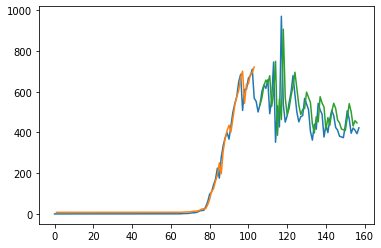

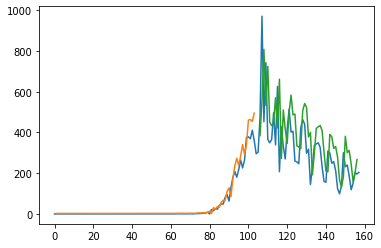

France


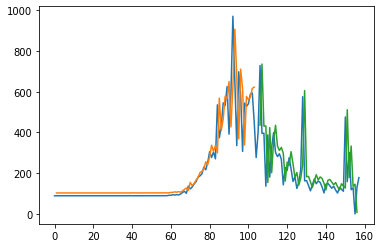

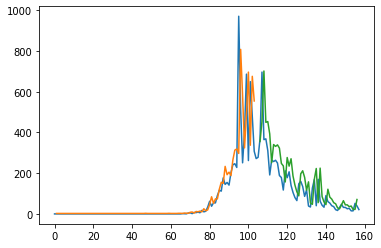

Italy


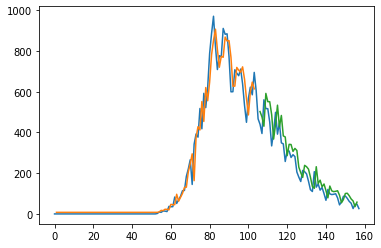

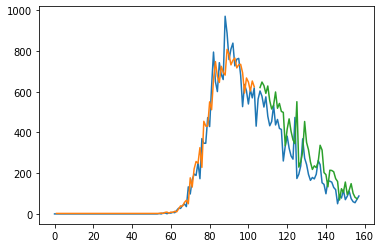

In [33]:
for ctc in ctclist:
  print(ctc)
  # shift train predictions for plotting
  trainPredictPlot_cases = np.empty_like(datasets_cases[ctc])
  trainPredictPlot_cases[:, :] = np.nan
  trainPredictPlot_cases[look_back:len(trainPredicts_cases[ctc])+look_back, :] = trainPredicts_cases[ctc]
  # shift test predictions for plotting
  testPredictPlot_cases = np.empty_like(datasets_cases[ctc])
  testPredictPlot_cases[:, :] = np.nan
  testPredictPlot_cases[len(trainPredicts_cases[ctc])+(look_back*2)+1:len(datasets_cases[ctc])-1, :] = testPredicts_cases[ctc]
  # plot baseline and predictions
  plt.plot(scaler.inverse_transform(datasets_cases[ctc]))
  plt.plot(trainPredictPlot_cases)
  plt.plot(testPredictPlot_cases)
  plt.show()

  # shift train predictions for plotting
  trainPredictPlot_deaths = np.empty_like(datasets_deaths[ctc])
  trainPredictPlot_deaths[:, :] = np.nan
  trainPredictPlot_deaths[look_back:len(trainPredicts_deaths[ctc])+look_back, :] = trainPredicts_deaths[ctc]
  # shift test predictions for plotting
  testPredictPlot_deaths = np.empty_like(datasets_deaths[ctc])
  testPredictPlot_deaths[:, :] = np.nan
  testPredictPlot_deaths[len(trainPredicts_deaths[ctc])+(look_back*2)+1:len(datasets_deaths[ctc])-1, :] = testPredicts_deaths[ctc]
  # plot baseline and predictions
  plt.plot(scaler.inverse_transform(datasets_deaths[ctc]))
  plt.plot(trainPredictPlot_deaths)
  plt.plot(testPredictPlot_deaths)
  plt.show()